Code for calculating the CEvNS rates for LiF at a reactor.
- Part 1: Generate neutrino flux
- Part 2: Calculate nuclear recoil distributions as a function of neutrino energy
- Part 3: Calculate cross section, recoil distribution

Part 1. The flux is given in neutrinos/fission for each of the main fissile isotopes. We use parameters from CONUS+ paper (https://arxiv.org/abs/2501.05206v1), and fluxes from Silaeva & Sinev (https://arxiv.org/abs/2012.09917). We use the effective thermal energy release per 
fission from https://arxiv.org/abs/1212.6625.

TODO:
- Form factors
- Add pion decay-at-rest neutrinos
- Calculate atoms_per_kg, look-up table or target_Zs, target_As

In [19]:
import numpy as np
import matplotlib.pyplot as plt 
import math

#Reactor constants
core_isotopes = ["235U","238U","239Pu","241Pu"]
core_fractions = [0.53,0.08,0.32,0.07]
power_GW = 3.6

distance_to_core_m = 20.7
exposure_days = 100

#https://arxiv.org/pdf/1212.6625
energy_per_fission_MeV_dict = {
  "235U":201.92,
  "238U":205.52,
  "239Pu":210.99,
  "241Pu":213.6
}
MeV_per_joule = 6241509343260.2

#Binning sizes
Enu_step_size_MeV = 0.001 
Enr_step_size_MeV = 0.000001

#Target constants
output_name = "LiF"
target_isotopes = ["$^{19}$F","$^{7}$Li","$^{6}$Li"]
target_Zs = np.array([9,3,3])
target_As = np.array([19,7,6])
target_fractions = [0.5,0.462,0.038] #isotopic
atoms_per_kg = np.array([3.17e25,8.583e25,1.001e26])
target_mass_kg = 0.1
'''
output_name = "Si"
target_isotopes = ["28Si"]
target_Zs = np.array([14])
target_As = np.array([28])
target_fractions = np.array([1.])
atoms_per_kg = np.array([2.144e25])
target_mass_kg = 1
'''
'''
output_name = "Na"
target_isotopes = ["23Na"]
target_Zs = np.array([11])
target_As = np.array([23])
target_fractions = np.array([1.])
atoms_per_kg = np.array([2.144e25])
target_mass_kg = 1
'''
'''
output_name = "Ge"
target_isotopes = ["73Ge"]
target_Zs = np.array([32])
target_As = np.array([73])
target_fractions = np.array([1.])
atoms_per_kg = np.array([8.258e24])
target_mass_kg = 1
'''

#Physics constants
hbarc_MeVcm = 197.327e-13
m_e = 0.51099895069 #MeV/c
GF_MeV2 = 1.1663788*math.pow(10,-11) #2024 PDG value
#Neutrino-quark couplings, from PDG 2024 edition
g_vu_LL = 0.3457
g_vd_LL = -0.4288
g_vu_LR = -0.1553
g_vd_LR = 0.0777
#Now calculate vector couplings to protons and neutrons
gp_V = 2*(g_vu_LL + g_vu_LR) + (g_vd_LL+g_vd_LR)
gn_V = (g_vu_LL + g_vu_LR) + 2*(g_vd_LL+g_vd_LR)
#Quark spin charges, from https://arxiv.org/pdf/1909.00485 Table XI
gA_u = 0.862
gA_d = -0.424
gA_s = -0.0458
#Now calculate axial couplings to protons and neutrons
gp_A = 0.5*(gA_u - gA_d - gA_s)
gn_A = 0.5*(-gA_u + gA_d - gA_s)

amu_to_MeV = 931.49410242
vector_form_factor = 1 #TODO
axial_form_factor = 1 #TODO

#################################
##Load nuclear data for targets##
#################################
#Loads the masses for calculating thresholds.
def loadMassTable(massTableFilename="data/mass_1.mas20.txt"):
  #Uses Chinese Phys. C 45 030002 (2021), and Chinese Phys. C 45 030003 (2021) as reported on https://www-nds.iaea.org/amdc/ to 
  #load up masses into a table Z,A,mass in microamu. We pad this table so we can index it directly from Z,A instead of having to worry about zero-indexing.
  massTable=np.zeros((300,300))
  firstLineNum=36
  for iline,line in enumerate(open(massTableFilename,"r")):
    if iline>=firstLineNum:
      if not line=="":
        line=line.strip("\n")
        line=line.replace("#","")
        lineParts=line.split()
        nLeadingSpaces = len(line) - len(line.lstrip(" "))
        if nLeadingSpaces==0:
          Z=int(lineParts[3])
          A=int(lineParts[4])
        else:
          Z=int(lineParts[2])
          A=int(lineParts[3])
        atomic_MeV=(float(lineParts[-3])*1000000+float(lineParts[-2]))*math.pow(10,-6)*amu_to_MeV
        nuclear_MeV = atomic_MeV - Z*m_e
        massTable[Z][A]=nuclear_MeV 
  return massTable

def loadSnSpTable(SnSnTableFilename="data/sn_sp.csv"):
  Sn_table = np.zeros((300,300))
  Sp_table = np.zeros((300,300))
  for iline,line in enumerate(open(SnSnTableFilename,"r")):
    if not line.startswith("#"):
      line = line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        Z = int(lineParts[0])
        A = int(lineParts[1])
        Sn = float(lineParts[2])
        Sp = float(lineParts[3])
        Sn_table[Z][A] = Sn
        Sp_table[Z][A] = Sp
  return Sn_table,Sp_table

mass_table = loadMassTable()
Sn_table,Sp_table = loadSnSpTable()

############################
##Calculate mass fractions##
############################
avg_nuclear_mass = np.sum([target_fractions[i]*mass_table[target_Zs[i]][target_As[i]] for i in range(0,len(target_fractions))])
target_mass_fractions =[target_fractions[i]*mass_table[target_Zs[i]][target_As[i]]/avg_nuclear_mass for i in range(0,len(target_fractions))]
print(target_mass_fractions)
target_nAtoms = np.array(target_mass_fractions) * target_mass_kg * np.array(atoms_per_kg)

#Plotting
colors=["tab:blue","tab:orange","tab:green","tab:red","tab:purple","black"]
plt.rcParams.update({'axes.titlesize': 14})
plt.rcParams.update({'axes.labelsize': 15})
plt.rcParams.update({'xtick.labelsize':13})
plt.rcParams.update({'ytick.labelsize':13}) 
plt.rcParams.update({'legend.fontsize':13}) 

[0.7324403877069672, 0.24993549726556544, 0.017624115027467392]


Per 235U fission, expect 3.26 neutrinos/fission
Per 235U fission, expect 3.53 neutrinos/fission (uninterpolated)
Per 238U fission, expect 4.16 neutrinos/fission
Per 238U fission, expect 4.46 neutrinos/fission (uninterpolated)
Per 239Pu fission, expect 2.78 neutrinos/fission
Per 239Pu fission, expect 3.04 neutrinos/fission (uninterpolated)
Per 241Pu fission, expect 3.45 neutrinos/fission
Per 241Pu fission, expect 3.74 neutrinos/fission (uninterpolated)
Fissions per second:1.0911305716433278e+20
Neutrino flux from 235U is 3.79e+12/cm2/sec at 20.7m from a 3.6GW core
Neutrino flux from 238U is 7.22e+11/cm2/sec at 20.7m from a 3.6GW core
Neutrino flux from 239Pu is 1.97e+12/cm2/sec at 20.7m from a 3.6GW core
Neutrino flux from 241Pu is 5.3e+11/cm2/sec at 20.7m from a 3.6GW core
235U 3791372880104.9663
238U 722407276978.7076
239Pu 1969023384618.9893
241Pu 529900291520.7911
Total neutrino flux for this configuration: 7e+12nu/cm2/sec


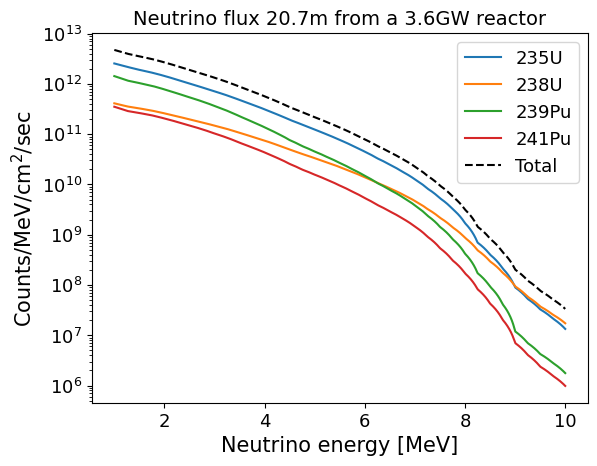

In [20]:
#Loads CSV of energy, neutrinos/fission/energy bin, returns np arrays
def loadFluxCSV(fname):
  f = open(fname,"r")
  energies = []
  fluxes = []
  for line in f:
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        energies.append(float(lineParts[0]))
        fluxes.append(float(lineParts[1]))
  return np.asarray(energies),np.asarray(fluxes)

#############
##Load data##
#############
raw_energy_arrs = []
raw_flux_arrs = []
raw_neutrinos_per_fission = []
for core_isotope in core_isotopes:
  fname = f"Silaeva_{core_isotope}_vebar.csv"
  raw_energy_arr,raw_flux_arr = loadFluxCSV("data/spectra/"+fname)
  raw_energy_arrs.append(raw_energy_arr)
  raw_flux_arrs.append(raw_flux_arr)
  raw_neutrinos_per_fission.append(np.sum(raw_flux_arr))

##################################################
##Get global min/max, interpolate with 0 padding##
##################################################
#Interpolate energy
e_min = np.min(raw_energy_arrs)
e_max = np.max(raw_energy_arrs)
interpolated_energy_arr = np.arange(e_min,e_max+Enu_step_size_MeV,Enu_step_size_MeV)

#Interpolate flux
interpolated_flux_arrs = []
for i,isotope in enumerate(core_isotopes):
  interpolated_flux_arrs.append(np.interp(interpolated_energy_arr,raw_energy_arr,raw_flux_arrs[i],left=0,right=0))
interpolated_flux_arrs = np.asarray(interpolated_flux_arrs)

#Update flux to match new binning
raw_bin_size = raw_energy_arrs[0][1] - raw_energy_arrs[0][0]
for i,interpolated_flux_arr in enumerate(interpolated_flux_arrs):
  interpolated_flux_arrs[i] = interpolated_flux_arr * Enu_step_size_MeV/raw_bin_size

for i,core_isotope in enumerate(core_isotopes):
  print(f"Per {core_isotope} fission, expect {np.sum(interpolated_flux_arrs[i]):.2f} neutrinos/fission")
  print(f"Per {core_isotope} fission, expect {np.sum(raw_flux_arrs[i]):.2f} neutrinos/fission (uninterpolated)")

#################
##Normalization##
#################
fig,ax = plt.subplots()
#Normalize sum to 1
for i,interpolated_flux_arr in enumerate(interpolated_flux_arrs):
  interpolated_flux_arrs[i] = interpolated_flux_arr / np.sum(interpolated_flux_arr)
          
#Calculate flux
joules_per_second = power_GW * math.pow(10,9)
MeV_per_second = joules_per_second * MeV_per_joule
avg_fission_energy_MeV = np.sum([energy_per_fission_MeV_dict[isotope]*core_fractions[i] for i,isotope in enumerate(core_isotopes)])
total_fissions_per_second = MeV_per_second/avg_fission_energy_MeV
print("Fissions per second:"+str(total_fissions_per_second))

#Scale interpolated fluxes
for i,interpolated_flux_arr in enumerate(interpolated_flux_arrs):

  isotope_fissions_per_second = core_fractions[i]*total_fissions_per_second
  interpolated_flux_arrs[i] = interpolated_flux_arrs[i] * raw_neutrinos_per_fission[i] * isotope_fissions_per_second
  interpolated_flux_arrs[i] = interpolated_flux_arrs[i] / (4*math.pi*math.pow(distance_to_core_m*100,2))
  ax.plot(interpolated_energy_arr,interpolated_flux_arrs[i]/Enu_step_size_MeV,label=core_isotopes[i])
  print(f"Neutrino flux from {core_isotopes[i]} is {np.sum(interpolated_flux_arrs[i]):.3g}/cm2/sec at {distance_to_core_m}m from a {power_GW}GW core")

for i,isotope in enumerate(core_isotopes):
  print(isotope,np.sum(interpolated_flux_arrs[i],axis=0))
total_interpolated_flux = np.sum(interpolated_flux_arrs,axis=0)
ax.plot(interpolated_energy_arr,total_interpolated_flux / Enu_step_size_MeV,"--",color="k",label="Total")
print(f"Total neutrino flux for this configuration: {np.sum(total_interpolated_flux):.2g}nu/cm2/sec")
plt.yscale("log")
plt.legend()
plt.xlabel("Neutrino energy [MeV]")
plt.ylabel("Counts/MeV/cm$^2$/sec")
plt.title(f"Neutrino flux {distance_to_core_m}m from a {power_GW}GW reactor")
plt.savefig("reactor_fluxes.png",dpi=300,bbox_inches="tight")
plt.show()

In [21]:
#Energy - Extend if want to plot xs to higher energies
interpolated_energy_arr = np.linspace(0,10,100)

###########################################################
##Calculate max recoil energy for highest energy neutrino##
########################################################### 
Enu_max_MeV = interpolated_energy_arr[-1]
T_max_MeV = 0
for i,target_isotope in enumerate(target_isotopes):
  test_Enu_max_MeV = 2*math.pow(Enu_max_MeV,2)/(mass_table[target_Zs[i]][target_As[i]]+2*Enu_max_MeV)
  if test_Enu_max_MeV > T_max_MeV:
    T_max_MeV = test_Enu_max_MeV

Ts_MeV = np.arange(Enr_step_size_MeV/2.,T_max_MeV+Enr_step_size_MeV/2.,Enr_step_size_MeV)

##################################
##CEvNS Cross Section Calculator##
##################################
#Based on https://arxiv.org/pdf/1803.09183, ignoring radiative corrections
prefix = math.pow(GF_MeV2,2)/(2.0*math.pi)
def calcCalcCrossSection(E_nu,M,Z,N,Sn,Sp):
  xs = np.zeros(Ts_MeV.size)

  G_V = (gp_V*Z + gn_V*N)*vector_form_factor
  G_A = (gp_A*2*Sp + gn_A*2*Sn) * axial_form_factor
  T_max = 2*math.pow(E_nu,2)/(M+2*E_nu)
  mask = (Ts_MeV <= T_max)

  Ts = Ts_MeV[mask]
  valid_xs = prefix * M * (np.power(G_V+G_A,2) + np.power(G_V-G_A,2) * np.power(1-Ts/E_nu,2) - (G_V**2 - G_A**2)*M*Ts / (E_nu**2))
  valid_xs = valid_xs * hbarc_MeVcm * hbarc_MeVcm #convert to cm2

  xs[:len(valid_xs)] = valid_xs

  xs_total = np.trapz(xs, Ts_MeV)

  xs = xs * Enr_step_size_MeV

  return np.asarray(xs),xs_total

############################################
##Loop through isotopes, neutrino energies##
############################################
cross_sections = []
differential_cross_sections = []
vector_cross_sections = []
for i,isotope in enumerate(target_isotopes):
  cross_sections.append([])
  vector_cross_sections.append([])
  differential_cross_sections.append([])
  Z = target_Zs[i]
  A = target_As[i]
  N = A - Z
  M = mass_table[Z][A]
  Sn = Sn_table[Z][A]
  Sp = Sp_table[Z][A]

  for E_nu in interpolated_energy_arr:
    differential_cross_section,total_cross_section = calcCalcCrossSection(E_nu,M,Z,N,Sn,Sp)
    cross_sections[i].append(total_cross_section)
    differential_cross_sections[i].append(differential_cross_section)

  Sn = 0
  Sp = 0
  for E_nu in interpolated_energy_arr:
    dummy,total_cross_section = calcCalcCrossSection(E_nu,M,Z,N,Sn,Sp)
    vector_cross_sections[i].append(total_cross_section)


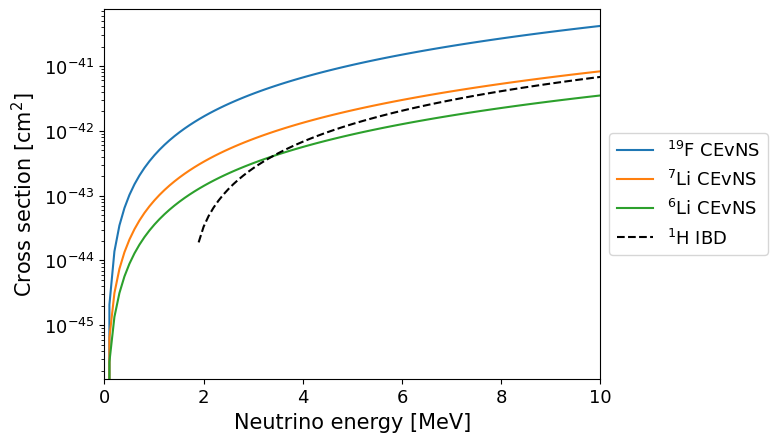

In [25]:
########
##Plot##
########
for i,isotope in enumerate(target_isotopes):
  plt.plot(interpolated_energy_arr,cross_sections[i],color=colors[i],label=target_isotopes[i]+" CEvNS")
  #plt.plot(interpolated_energy_arr,vector_cross_sections[i],"--",color=colors[i],label=target_isotopes[i]+" (vector only)")
  #print(np.sum(np.array(cross_sections[i])*total_interpolated_flux*np.array(target_nAtoms[i])*86400*exposure_days))

  '''
  print(cross_sections[i])
  print(vector_cross_sections[i])
  diff = np.array([abs(cross_sections[i][j] - vector_cross_sections[i][j])/cross_sections[i][j] if cross_sections[i][j] > 0 else 0 for j in range(0,len(cross_sections[i]))])
  plt.plot(interpolated_energy_arr,diff)
  '''

'''
#Just for fun, inelastic NC xs from HC Lee
def calcInelastic(arr,threshold_MeV,ga_sigmatau3_squared):
  inelastic_xs = []
  for nrg in arr:
    if nrg <= threshold_MeV:
      inelastic_xs.append(0.)
    else:
      inelastic_xs.append(4.2e-45*math.pow(nrg-threshold_MeV,2)*ga_sigmatau3_squared)
  return inelastic_xs

inelastic_thresholds = [0.478,1.554]
inelastic_matrixelements = [1.78,0.05]
inelastic_names = ["$^7$Li (0.478 MeV)","$^{19}$F (1.554 MeV)"]
for i,thresh in enumerate(inelastic_thresholds):
  inelastic_xs = calcInelastic(interpolated_energy_arr,thresh,inelastic_matrixelements[i])
  plt.plot(interpolated_energy_arr,inelastic_xs,color=colors[i+4],label=inelastic_names[i],ls="dashed")
'''


#Optional - load IBD xs
#https://arxiv.org/pdf/2311.16730
ibdFilename = "xs_arxiv2311.16730.csv"
ibd_energies = []
ibd_xs = []
with open(ibdFilename,"r") as ibdFile:
  for iline,line in enumerate(ibdFile):
    if iline>0:
      line = line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        ibd_energies.append(float(lineParts[0]))
        ibd_xs.append(float(lineParts[1])*math.pow(10,-41))
plt.plot(ibd_energies,ibd_xs,label = "$^{1}$H IBD",color="black",ls="dashed")


plt.legend(loc="right")
#plt.yscale("log")
plt.xlabel("Neutrino energy [MeV]")
plt.ylabel("Cross section [cm$^2$]")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlim(left=0,right=10)
plt.yscale("log")
#plt.ylim(0.0015,0.0025)
plt.savefig("LiF_xs_withIBD_LE.png",dpi=300,bbox_inches="tight")


plt.show()


In [23]:
#################################
##Calculate recoil distribution##
#################################
differential_recoil_distributions = [np.zeros(Ts_MeV.size) for isotope in target_isotopes]

for itarget,isotope in enumerate(target_isotopes):
  #1. Step through neutrino energies, calculate flux in that bin (value * bin width)
  for inrg,E_nu in enumerate(interpolated_energy_arr):
    fluence = total_interpolated_flux[inrg] * 86400 * exposure_days

    #2. Step through recoil distributions, scale by flux and targets, add to global recoil list
    differential_counts = differential_cross_sections[itarget][inrg] * fluence * target_nAtoms[itarget]
    differential_recoil_distributions[itarget] = differential_recoil_distributions[itarget] + differential_counts


  differential_recoil_distributions[itarget] = differential_recoil_distributions[itarget]


For $^{19}$F, expect 126.9 counts
For $^{7}$Li, expect 23.4 counts
For $^{6}$Li, expect 0.8 counts


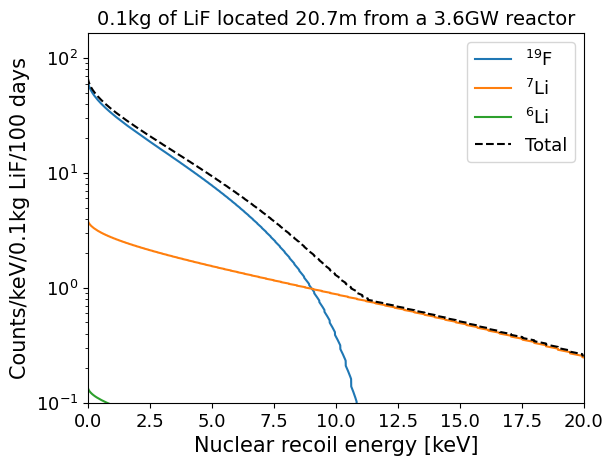

In [24]:
########
##PLOT##
########
scaleFactor = 0.001/Enr_step_size_MeV
Ts_keV = Ts_MeV*1000
fig,ax = plt.subplots()
for itarget,isotope in enumerate(target_isotopes):
  ax.plot(Ts_keV,differential_recoil_distributions[itarget]*scaleFactor, label=target_isotopes[itarget])
  integrated_counts = np.trapz(differential_recoil_distributions[itarget]/Enr_step_size_MeV,Ts_MeV)
  print(f"For {target_isotopes[itarget]}, expect {integrated_counts:.1f} counts")

total_recoil_dist = np.sum(differential_recoil_distributions, axis=0)*scaleFactor
ax.plot(Ts_keV,total_recoil_dist,"--",label="Total",color="k")
plt.legend()
plt.yscale("log")
plt.xlabel("Nuclear recoil energy [keV]")
plt.ylabel(f"Counts/keV/{target_mass_kg}kg {output_name}/{exposure_days} days")
plt.title(f"{target_mass_kg}kg of {output_name} located {distance_to_core_m}m from a {power_GW}GW reactor")
ax.set_xlim(left=0,right=20)
ax.set_ylim(bottom=0.1)
plt.savefig("LiF_recoilDist.png",dpi=300,bbox_inches="tight")
plt.show()